## Libraries

In [298]:
import pandas as pd
import numpy as np

import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve,
                             auc)

import time
from pathlib import Path
import os
import joblib
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [299]:
# # download Datasets
# ! kaggle competitions download -c fake-news
# ! unzip fake-news.zip -d Database
# ! rm fake-news.zip

## Data Analysis

---
**Project Objective:**

Our objective is to predict if the news are reliable or trying to spread missinformation. <br/>
<br/>
Labels: <br/>
&emsp;0: reliable  <br/>
&emsp;1: unreliable  <br/>

---

In [300]:
data = pd.read_csv(r'Database/train.csv')[['title', 'author', 'label']]

In [301]:
data

,title,author,label
0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,1
3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,1
4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,1
...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White Supremacy’,Jerome Hudson,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds - The New York Times",Benjamin Hoffman,0
20797,Macy’s Is Said to Receive Takeover Approach by Hudson’s Bay - The New York Times,Michael J. de la Merced and Rachel Abrams,0
20798,"NATO, Russia To Hold Parallel Exercises In Balkans",Alex Ansary,1


In [302]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   label   20800 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 487.6+ KB


In [303]:
# okay we have duplicates so let's remove them
data.describe(include=['O'])

,title,author
count,20242,18843
unique,19803,4201
top,Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence,Pam Key
freq,5,243


In [304]:
# see if our dataset is balanced or not.
data.value_counts(subset='label', dropna=True)

label
1    10413
0    10387
Name: count, dtype: int64

---
**Problem Statement:**

1. Need to deal with the duplicate values
2. Gather information on the null values and find the best way to deal with them
3. Check which authors are the most reliable, their names might be seen as very important features in our model

---

In [305]:
data.drop_duplicates(inplace=True)

In [306]:
data.isna().sum()

title      369
author    1922
label        0
dtype: int64

In [307]:
# okay so 99% of the time the author is null it comes from an unreliable source
data[data['author'].isna()].value_counts(subset='label', normalize= True)

label
1    0.986472
0    0.013528
Name: proportion, dtype: float64

In [308]:
# every time the title is null it's an unreliable source
data[data['title'].isna()].value_counts(subset='label', normalize= True)

label
1    1.0
Name: proportion, dtype: float64

In [309]:
data.fillna({'title': 'no title', 'author': 'no author'}, inplace=True)

Note: Since every time we have a missing value it a news spreading missinformation we want our model to learn that pattern so we will fill them

In [310]:
# from which author are the most reliable
authors = data.pivot_table(index='author', columns='label', aggfunc='size', fill_value=0).reset_index()
authors.columns = ['author', 'reliable', 'unreliable']

In [311]:
authors.sort_values('reliable', ascending= False)

,author,reliable,unreliable
2944,Pam Key,242,1
1762,Jerome Hudson,166,0
724,Charlie Spiering,141,0
1857,John Hayward,140,0
2090,Katherine Rodriguez,124,0
...,...,...,...
1782,Jhayla Walls,0,1
1783,Jim,0,1
1784,Jim Davis,0,1
1787,Jim Hightower,0,1


In [312]:
authors.sort_values('unreliable', ascending= False)

,author,reliable,unreliable
4079,no author,26,1896
3929,admin,0,192
2939,Pakalert,0,85
1111,Eddy Lavine,0,85
3518,Starkman,0,84
...,...,...,...
2490,Matt Richtel and Andrew Pollack,1,0
2491,Matt Stevens,1,0
1049,Dionne Searcey,5,0
2493,Matthew Boyle,33,0


---
**Problem Statement:**

1. See the distribution of the text length between both labels
2. See if the presence of symbols in text is an indicator that the news are fake

---

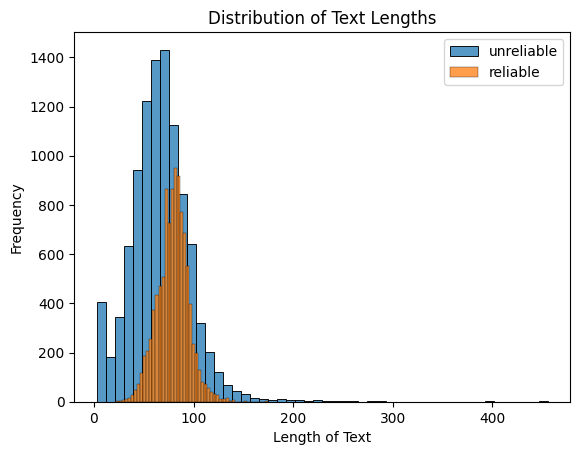

In [315]:
sns.histplot(data[data['label'] == 1]['title'].str.len(), bins=50, label= 'unreliable')
sns.histplot(data[data['label'] == 0]['title'].str.len(), bins=50,label= 'reliable')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.savefig('Fig/text_distribution.jpeg')
plt.show()

In [316]:
data['text'] = data['title'] + ' by ' + data['author']

In [317]:
# want to check if having emojis in the tile or name is a sign of being from an unreliable source
# since only two rows out of 10k have emoji i don't see a point in replacing all emojis for a word
# i can just remove the emojis as i will do for punctuation
_ = data.copy()
def contains_unicode_symbols(text):
    emoji_ranges = (
        (0x1F600, 0x1F64F),  # emoticons
        (0x1F300, 0x1F5FF),  # symbols & pictographs
        (0x1F680, 0x1F6FF),  # transport & map symbols
        (0x1F1E0, 0x1F1FF)   # flags (iOS)
    )
    
    for emoji_range in emoji_ranges:
        for char in text:
            if emoji_range[0] <= ord(char) <= emoji_range[1]:
                return True
    return False

_['has_emoji'] = _['text'].apply(contains_unicode_symbols)
_[_['has_emoji']]


,title,author,label,text,has_emoji
6517,Re: Michelle Obama calls for a ‘president who takes the job seriously’,MarciaTheMurkyMuse🌠 Variegated,1,Re: Michelle Obama calls for a ‘president who takes the job seriously’ by MarciaTheMurkyMuse🌠 Variegated,True
10266,🚨Bill Clinton and Hillary Lolita Express Pedophilia Ring🚨,Alex Ansary,1,🚨Bill Clinton and Hillary Lolita Express Pedophilia Ring🚨 by Alex Ansary,True


---
**Problem Statement:**

1. Clean the text
2. Study which preprocessing method is better at creating a pattern that is able to easily differentiate unreliable from reliable news

---

In [318]:
# cleans (removes symbols, punctuation, emojis, stopwords and stems the words) and tokenizes our textual data
stop_words = stopwords.words('english')
ss = SnowballStemmer(language='english')

def f_tokenizer(x):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 ]+', ' ', x) # removes all the symbols, emojis, punctuation marks
    tokens = cleaned_text.split() # splits on whitespaces
    remove_stopwords = [ss.stem(word) for word in tokens if tokens not in stop_words] # removes stopwords and stemms them
    
    return remove_stopwords
    

In [165]:
# we can compare both to see if they perform the same or if tfidf performs better
cv_vect = CountVectorizer(tokenizer= f_tokenizer, max_features = 5000, token_pattern = None)
cv_trainset = cv_vect.fit_transform(data['text']).toarray()

tfidf_vect = TfidfVectorizer(tokenizer= f_tokenizer, max_features = 5000, token_pattern = None)
tfidf_trainset = tfidf_vect.fit_transform(data['text']).toarray()

In [166]:
# reduce the dimensionality of our data so we can be visualize it in a 2D chart.
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=2)
cv_lsa_scores = lsa.fit_transform(cv_trainset)

tfidf_lsa_scores= lsa.fit_transform(tfidf_trainset)

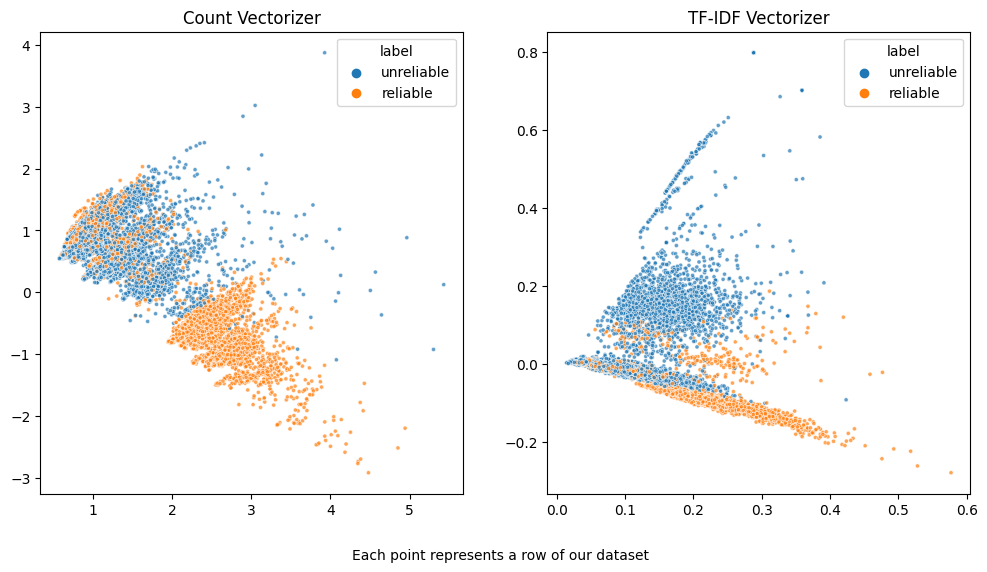

In [320]:
# in this case since there is such a visable difference between both labels in each method, they might perform similarly
fig, ax = plt.subplots(1,2, figsize=(12, 6) )
mapping = {0: 'reliable', 1: 'unreliable'}
sns.scatterplot(x = cv_lsa_scores[:,0], y =cv_lsa_scores[:,1], hue= data['label'].map(mapping), alpha= 0.7, marker= '.', ax=ax[0])
ax[0].set_title('Count Vectorizer')
sns.scatterplot(x = tfidf_lsa_scores[:,0], y =tfidf_lsa_scores[:,1], hue= data['label'].map(mapping), alpha= 0.7, marker= '.', ax=ax[1])
ax[1].set_title('TF-IDF Vectorizer')
plt.text(-0.3,-0.5, 'Each point represents a row of our dataset')
plt.savefig('Fig/preprocessing_methods.jpeg')
plt.show()

Note: each point represents a row of our dataset

## Train Models

---
**Problem Statement:**

1. Create a training and validation dataset
2. Train and compare models 

---

In [168]:
cv_train, cv_val, tf_train, tf_val, y_train, y_val = train_test_split(cv_trainset, 
                                                                      tfidf_trainset, 
                                                                      data['label'], 
                                                                      test_size= 0.33, 
                                                                      random_state=0)

In [169]:
cv_train.shape, cv_val.shape

((13676, 5000), (6736, 5000))

In [170]:
tf_train.shape, tf_val.shape

((13676, 5000), (6736, 5000))

In [171]:
models = [(LogisticRegression(random_state= 0), "LR"), 
          (CalibratedClassifierCV(LinearSVC(random_state= 0)), "SVC"), 
          (RandomForestClassifier(random_state= 0 ,n_jobs= -1), "RF"), 
          (XGBClassifier(), "XGBoost")
          ]

datasets = [(cv_train, cv_val, "CountVectorizer"), 
            (tf_train, tf_val, "TF-IDFVectorizer")]

In [172]:
metrics = defaultdict(dict)
cwd = Path.cwd()
sub_path = "models"

for model, model_name in models:
  for X_train, X_val, pp_method in datasets:
    print(f'Starting {model_name} using {pp_method}')

    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    seconds = round(end - start)
    print(f'finished {model_name} training using {pp_method} in {seconds // 60:02d}:{seconds%60:02d}\n')

    print("Saving model ...")
    sample_dir = cwd / sub_path / model_name
    sample_dir.mkdir(parents=True, exist_ok=True)
    output = os.path.join(sample_dir, pp_method + ".joblib")
    joblib.dump(model, output)
    print("Computing metrics ...\n")

    size = os.stat(output).st_size / (1024 * 1024)

    pred_prob = model.predict_proba(X_val)
    y_pred = pred_prob.argmax(axis=1)
    fpr, tpr, thresholds = roc_curve(y_val, pred_prob[:,1])
    metrics[model_name][pp_method] = {'Accuracy': accuracy_score(y_val, y_pred), 
                    'Precision': precision_score(y_val, y_pred),
                    'Recall': recall_score(y_val, y_pred),
                    'F1 score': f1_score(y_val, y_pred),
                    'fpr': fpr,
                    'tpr': tpr,
                    'thresholds': thresholds,
                    'AOC Score': auc(fpr, tpr),
                    'Time Taken': seconds,
                    'Model Path': output,
                    'Size in MB': size
                    }
    
joblib.dump(dict(metrics), cwd / sub_path / "metrics.joblib")

Starting LR using CountVectorizer
finished LR training using CountVectorizer in 00:03

Saving model ...
Computing metrics ...

Starting LR using TF-IDFVectorizer
finished LR training using TF-IDFVectorizer in 00:01

Saving model ...
Computing metrics ...

Starting SVC using CountVectorizer
finished SVC training using CountVectorizer in 00:04

Saving model ...
Computing metrics ...

Starting SVC using TF-IDFVectorizer
finished SVC training using TF-IDFVectorizer in 00:02

Saving model ...
Computing metrics ...

Starting RF using CountVectorizer
finished RF training using CountVectorizer in 00:10

Saving model ...
Computing metrics ...

Starting RF using TF-IDFVectorizer
finished RF training using TF-IDFVectorizer in 00:09

Saving model ...
Computing metrics ...

Starting XGBoost using CountVectorizer
finished XGBoost training using CountVectorizer in 00:03

Saving model ...
Computing metrics ...

Starting XGBoost using TF-IDFVectorizer
finished XGBoost training using TF-IDFVectorizer in

['/Users/goncalomoura/Documents/Data_science/Portfolio/Fake_news/models/metrics.joblib']

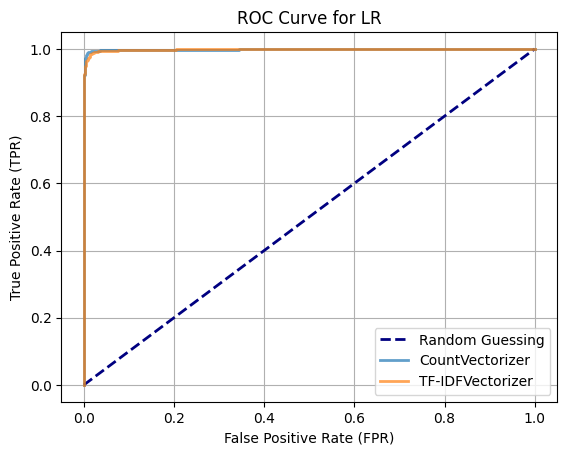

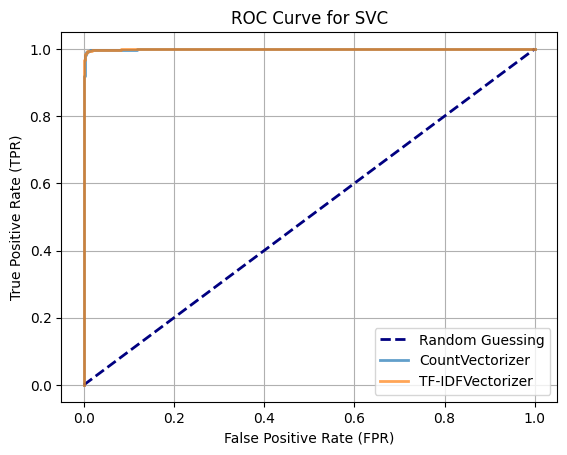

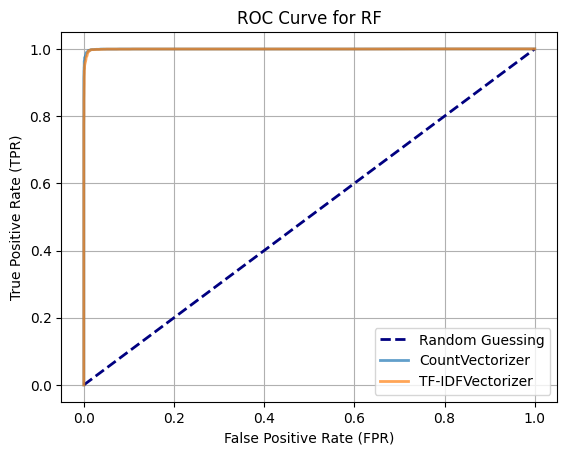

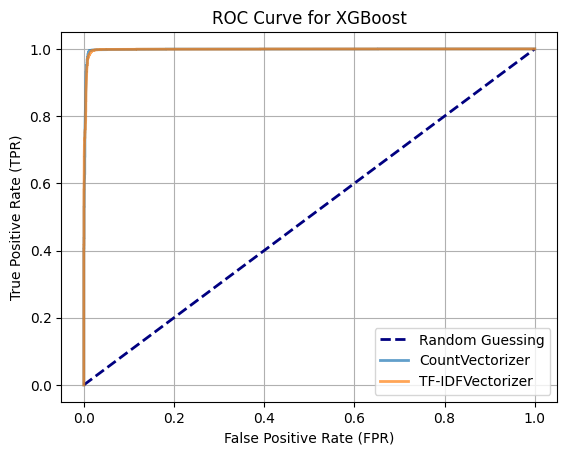

In [321]:
for model in metrics.keys():
  plt.figure()
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
  plt.plot(metrics[model]['CountVectorizer']['fpr'], metrics[model]['CountVectorizer']['tpr'], lw=2, label='CountVectorizer', alpha = 0.7)
  plt.plot(metrics[model]['TF-IDFVectorizer']['fpr'], metrics[model]['TF-IDFVectorizer']['tpr'], lw=2, label='TF-IDFVectorizer', alpha = 0.7)
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title(f'ROC Curve for {model}')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.savefig(f'Fig/ROC_AUC_{model}_CURVE.jpeg')
  plt.show()

In [174]:
lst = []
for models in metrics.keys():
  for pp in metrics[models].keys():
    _ = {key: value for key, value in metrics[models][pp].items() if key not in ['fpr', 'tpr', 'thresholds', 'Model Path']}
    _.update({"model": models, "method": pp})
    lst.append(_)

metrics_table = pd.DataFrame(lst).set_index(['model', 'method'])
metrics_table

Accuracy  Precision    Recall  F1 score  AOC Score  \
model   method                                                                 
LR      CountVectorizer   0.987827   0.983005  0.992474  0.987717   0.998185   
        TF-IDFVectorizer  0.981888   0.972813  0.990969  0.981807   0.998094   
SVC     CountVectorizer   0.991390   0.989796  0.992775  0.991283   0.998382   
        TF-IDFVectorizer  0.992280   0.993064  0.991270  0.992166   0.999050   
RF      CountVectorizer   0.990499   0.983383  0.997592  0.990436   0.999547   
        TF-IDFVectorizer  0.990499   0.983383  0.997592  0.990436   0.999297   
XGBoost CountVectorizer   0.990053   0.983655  0.996388  0.989981   0.997825   
        TF-IDFVectorizer  0.985897   0.974978  0.996990  0.985861   0.997854   

                          Time Taken  Size in MB  
model   method                                    
LR      CountVectorizer            3    0.038970  
        TF-IDFVectorizer           1    0.038970  
SVC     CountVectorizer            4    0.193578  
        TF-IDFVectorizer           2    0.193578  
RF      CountVectorizer           10   18.380410  
        TF-IDFVectorizer           9   17.403237  
XGBoost CountVectorizer            3    0.124701  
        TF-IDFVectorizer           9    0.130797

In [175]:
# since we don't have specific requirements for what model we need we can choose the simplest one (LR in this case) 
# and TF-IDF since it's more efficent for our sparse/ large dataset
metrics_table.loc[('LR', 'TF-IDFVectorizer')]

Accuracy      0.981888
Precision     0.972813
Recall        0.990969
F1 score      0.981807
AOC Score     0.998094
Time Taken    1.000000
Size in MB    0.038970
Name: (LR, TF-IDFVectorizer), dtype: float64

## Model explanability

In [176]:
import shap
np.random.seed(101)
shap.initjs()

In [177]:
model = joblib.load('models/LR/TF-IDFVectorizer.joblib')

In [178]:
explainer = shap.Explainer(model, tfidf_trainset, feature_names=tfidf_vect.get_feature_names_out())
shap_values = explainer(tfidf_trainset)

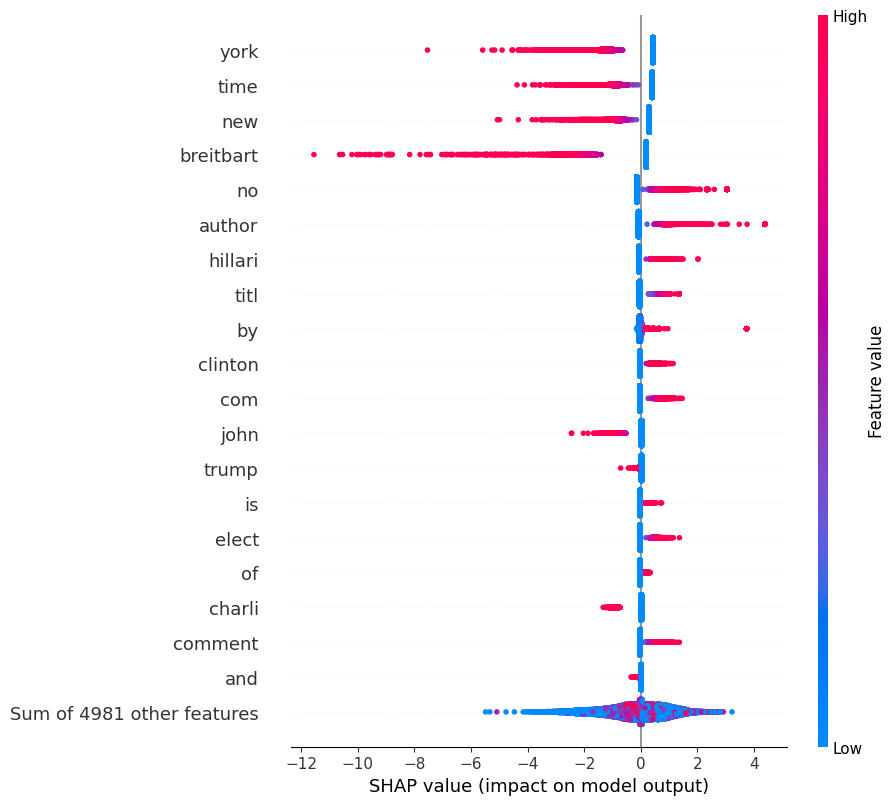

In [323]:
# in our use case low shap value means that more rows with that word are reliable 
# and the higher our shap value more rows with that words are unreliable
# from this we can see that new york time or breitbart (which seems to be a signature before the author name) as a big influence on our models decision
# as well as no author or no title, like we previously had seen the majority of missing title/author come from unreliable sources

shap.plots.beeswarm(shap_values, max_display= 20, show=False)
plt.savefig('Fig/shap_beeswarm.jpeg')

In [257]:
# it's present in the title that is why we haven't seen in before
print('Example: ', data[data['title'].str.contains('New York Times')]['text'].iloc[0])
data[data['title'].str.contains('New York Times')]['label'].value_counts()

Example:  Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times by Alissa J. Rubin


label
0    6229
1      12
Name: count, dtype: int64

In [262]:
# it's present in the title that is why we haven't seen in before
print('Example: ', data[data['title'].str.contains('Breitbart')]['text'].iloc[4])
data[data['title'].str.contains('Breitbart')]['label'].value_counts()

Example:  EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


label
0    2352
1       4
Name: count, dtype: int64

In [268]:
data[data['title'].str.contains('Breitbart')]['text']

1                                                                             FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart by Daniel J. Flynn
5        Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart by Daniel Nussbaum
19                                                                    Chuck Todd: ’BuzzFeed Did Donald Trump a Political Favor’ - Breitbart by Jeff Poor
22                                                                                       Rob Reiner: Trump Is ’Mentally Unstable’ - Breitbart by Pam Key
26          EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked
                                                                              ...                                                                       
20759                                   Coulter Calls Out ’Beta Males’ for Threate

EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


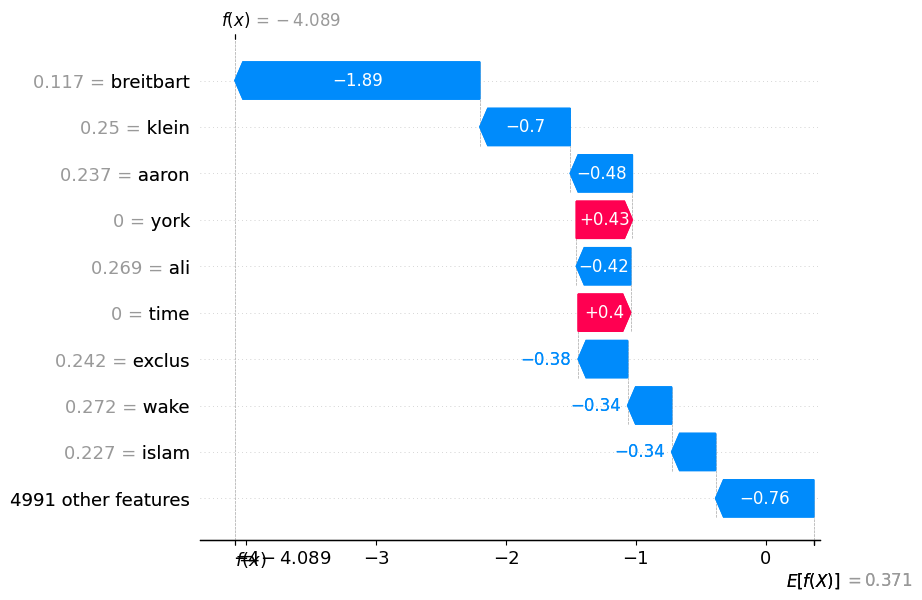

In [328]:
ind = 26
print(data['text'].iloc[ind])

shap.plots.waterfall(shap_values[ind])
plt.savefig('Fig/shap_waterfall.jpeg')

In [271]:
shap.plots.force(shap_values[ind])

In [273]:
print("Unreliable" if data['label'].iloc[ind] else "Reliable", "News:")
print(data['text'].iloc[ind])

Reliable News:
EXCLUSIVE: Islamic State Supporters Vow to ‘Shake’ the West Following Manchester Terrorist Massacre - Breitbart by Aaron Klein and Ali Waked


## Machine Learning Pipeline

---
**Problem Statement:**

1. Creating a machine learning pipeline that can be deployed to later predict if a sentence is fake or not

---

In [39]:
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import joblib

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

class Preprocessing_text(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
        
    def transform(self, X):
        
        if isinstance(X, list):
            return X
        
        X = X.copy()
        
        X = X.fillna({'title': 'no title', 'author': 'no author'})
        X['text'] = X['title'] + ' by ' + X['author']
        
        return X['text']

# cleans (removes symbols, punctuation, emojis, stopwords and stems the words) and tokenizes our textual data
stop_words = stopwords.words('english')
ss = SnowballStemmer(language='english')

def f_tokenizer(x):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 ]+', ' ', x) # removes all the symbols, emojis, punctuation marks
    tokens = cleaned_text.split() # splits on whitespaces
    remove_stopwords = [ss.stem(word) for word in tokens if tokens not in stop_words] # removes stopwords and stemms them
    
    return remove_stopwords


pipe = Pipeline(steps = [('preprocessing', Preprocessing_text()),
                         ('tfidf', TfidfVectorizer(tokenizer= f_tokenizer, max_features= 5000)), 
                         ('estimator', LogisticRegression(random_state= 0))])

In [40]:
data = pd.read_csv(r'Database/train.csv')[['title', 'author', 'label']].drop_duplicates()
X_train = data[['title', 'author']]
y_train = data['label']
X_train.shape, y_train.shape

((20412, 2), (20412,))

In [41]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', Preprocessing_text()),
                ('tfidf',
                 TfidfVectorizer(max_features=5000,
                                 tokenizer=<function f_tokenizer at 0x7f9f0149fdc0>)),
                ('estimator', LogisticRegression(random_state=0))])

In [42]:
# examples use of the pipeline to do the preprocessing and predictions of a row
pipe.predict(pd.DataFrame({"title": ['Donald Trump was caugth naked in the white house'],
                           "author": ['donald trump']}))

array([1])

In [43]:
# we can also feed it a list if we want to where each element is a row.
pipe.predict(['Donald Trump was caugth naked in the white house by donald trump',
              'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It by Darrell Lucus',
              'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart by Daniel J. Flynn'])

array([1, 1, 0])